In [2]:
from datasets import load_dataset
from pinecone_text.sparse import BM25Encoder
from pinecone import Pinecone, ServerlessSpec
from DLAIUtils import Utils

from dotenv import load_dotenv, find_dotenv
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
import torch
import os

_ = load_dotenv(find_dotenv())

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [4]:
import openai
openai.api_key = os.environ['OPENAI_API_KEY']

INDEX_NAME = f'dl-ai-{openai.api_key[-36:].lower().replace("_", "-")}'

pinecone = Pinecone(api_key=os.environ['PINECONE_API_KEY'])

if INDEX_NAME in [index.name for index in pinecone.list_indexes()]:
  pinecone.delete_index(INDEX_NAME)

pinecone.create_index(
  INDEX_NAME,
  dimension=512,
  metric='dotproduct',
  spec=ServerlessSpec(cloud='aws', region='us-west-2')
)

index = pinecone.Index(INDEX_NAME)

In [5]:
fashion = load_dataset(
    "ashraq/fashion-product-images-small",
    split="train"
)
fashion

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/44072 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
    num_rows: 44072
})

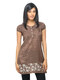

In [6]:
images = fashion['image']
metadata = fashion.remove_columns('image')
images[900]

In [7]:
metadata = metadata.to_pandas()
metadata.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [8]:
bm25 = BM25Encoder()
bm25.fit(metadata['productDisplayName'])
metadata['productDisplayName'][0]

  0%|          | 0/44072 [00:00<?, ?it/s]

'Turtle Check Men Navy Blue Shirt'

In [10]:
bm25.encode_queries(metadata['productDisplayName'][0])


{'indices': [23789636,
  1830646559,
  632192512,
  931643408,
  3905155331,
  3828986392],
 'values': [0.3276687848622804,
  0.19377339510596148,
  0.040475545164610806,
  0.1808640794607714,
  0.10791423980552016,
  0.1493039556008558]}

In [11]:
bm25.encode_documents(metadata['productDisplayName'][0])

{'indices': [23789636,
  1830646559,
  632192512,
  931643408,
  3905155331,
  3828986392],
 'values': [0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887]}

In [12]:
model = SentenceTransformer("sentence-transformers/clip-ViT-B-32", device=device)
model

.gitattributes:   0%|          | 0.00/690 [00:00<?, ?B/s]

0_CLIPModel/config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

0_CLIPModel/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

0_CLIPModel/preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

0_CLIPModel/special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

0_CLIPModel/tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

0_CLIPModel/vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

SentenceTransformer(
  (0): CLIPModel()
)

In [21]:
dense_vec = model.encode([metadata['productDisplayName'][0]])
dense_vec.shape

(1, 512)

In [32]:
batch_size = 200

for i in tqdm(range(0, len(fashion), batch_size)):
    i_end = min(i+batch_size, len(fashion))
    meta_batch = metadata.iloc[i:i_end]
    meta_dict = meta_batch.to_dict(orient='records')
    meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(["id", "year"])].values.tolist()]
    img_batch = images[i:i_end]
    sparse_embeds = bm25.encode_documents([text for text in meta_batch])
    dense_embeds = model.encode(img_batch).tolist()
    ids = [str(x) for x in range(i, i_end)]

    upserts = []
    for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
        upserts.append({
            "id": _id,
            "sparse_values": sparse,
            "values": dense,
            "metadata": meta
        })

    index.upsert(upserts)

index.describe_index_stats()

  0%|          | 0/221 [00:00<?, ?it/s]

{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 44000}},
 'total_vector_count': 44000}

In [33]:
query = "dark blue french connection jeans for men"

sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()

result = index.query(
    top_k=14,
    vector=dense,
    sparse_vector=sparse,
    include_metadata=True
)

imgs = [images[int(r['id'])] for r in result['matches']]
imgs

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>]


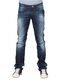
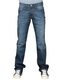
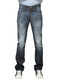
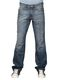
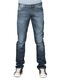
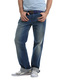
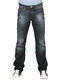
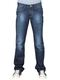
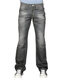
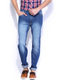
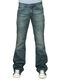
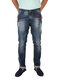
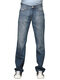
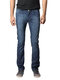

In [36]:
from IPython.core.display import HTML
from io import BytesIO
from base64 import b64encode

# function to display product images
def display_result(image_batch):
    figures = []
    for img in image_batch:
        b = BytesIO()
        img.save(b, format='png')
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px" >
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')


display_result(imgs)


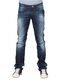
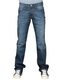
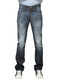
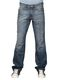
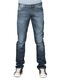
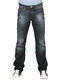

In [38]:
def hybrid_scale(dense, sparse, alpha: float):
    """Hybrid vector scaling using a convex combination

    alpha * dense + (1 - alpha) * sparse

    Args:
        dense: Array of floats representing
        sparse: a dict of `indices` and `values`
        alpha: float between 0 and 1 where 0 == sparse only
               and 1 == dense only
    """
    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
    # scale sparse and dense vectors to create hybrid search vecs
    hsparse = {
        'indices': sparse['indices'],
        'values':  [v * (1 - alpha) for v in sparse['values']]
    }
    hdense = [v * alpha for v in dense]
    return hdense, hsparse
    

question = "dark blue french connection jeans for men"
# Closer to 0 = more sparse vector influence, closer to 1 = more dense layer influence

hdense, hsparse = hybrid_scale(dense, sparse, alpha = 1)
result = index.query(
    top_k=6,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)

imgs = [images[int(r['id'])] for r in result['matches']]
display_result(imgs)

In [39]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

Locomotive Men Radley Blue Jeans
Locomotive Men Eero Blue Jeans
Locomotive Men Race Blue Jeans
Locomotive Men Ian Blue Jeans
Locomotive Men Cam Blue Jeans
Locomotive Men Cael Blue Jeans



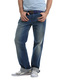
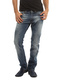
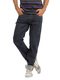
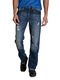
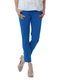
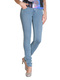

In [40]:
question = "dark blue french connection jeans for men"
#Closer to 0==more sparse, closer to 1==more dense
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0)
result = index.query(
    top_k=6,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
imgs = [images[int(r["id"])] for r in result["matches"]]
display_result(imgs)

In [41]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Women Blue Jeans
French Connection Women Blue Jeans



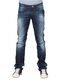
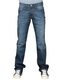
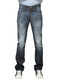
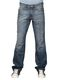
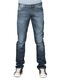
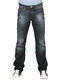

In [42]:
question = "dark blue french connection jeans for men"
#Closer to 0==more sparse, closer to 1==more dense
hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
result = index.query(
    top_k=6,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
imgs = [images[int(r["id"])] for r in result["matches"]]
display_result(imgs)


In [43]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

Locomotive Men Radley Blue Jeans
Locomotive Men Eero Blue Jeans
Locomotive Men Race Blue Jeans
Locomotive Men Ian Blue Jeans
Locomotive Men Cam Blue Jeans
Locomotive Men Cael Blue Jeans
